# Import libraries

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time
import cv2
import pickle
import mediapipe as mp
import tensorflow as tf

from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2022-06-07 12:23:24.489123: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
ROUND = 6
SEQ_LEN = 8
EXERCISE = 'squat'
CUR_CLASS = 'up'
PREV_CLASS = 'down'
SUBFIX_VID_NAME = '_hard_vote'
REMOTE = True

# Define mediapipe functions

In [3]:
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Load all file paths

In [4]:
all_file_paths = []
vid_to_seqs = {}
if REMOTE:
    walk_path = f'/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\keypoints_seq\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in tqdm(os.walk(walk_path)):
    if files:
        split = path.split(os.path.sep)
        vid_name = os.path.join(split[-2], split[-1]) # pushup-up/10_1
        sub_arr = []
        for name in files:
            if name.endswith('.npy'):
                full_path = os.path.join(path, name)
                all_file_paths.append(full_path)
                sub_arr.append(full_path)
        vid_to_seqs[vid_name] = sub_arr

494it [00:00, 16523.54it/s]


In [5]:
all_file_paths

['/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_38_2/38_2_4.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_38_2/38_2_3.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_38_2/38_2_5.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_38_2/38_2_2.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_38_2/38_2_1.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_28_2/28_2_5.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_28_2/28_2_3.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-jack-down_28_2/28_2_4.npy',
 '/data1-6tb/jom/Dataset/EzFit_dataset/train/keypoints_seq/len_8/squat/others/jumping-ja

In [6]:
len(all_file_paths)

15440

In [7]:
# use for stratify and check balance
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
# labels

In [8]:
# all data
Counter(labels)

Counter({'others': 3221, 'idle': 4291, 'squat-down': 4291, 'squat-up': 3637})

In [12]:
# check balanceness
# total = len(labels)
# label_count = Counter(labels)
# label_count, total

In [9]:
def load_numpy(path):
    return np.load(path.numpy())

In [10]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32
    data = tf.reshape(data, (99*SEQ_LEN,))
    
    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess

In [11]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['idle', 'others', 'squat-down', 'squat-up'], dtype='<U10')

In [12]:
labels = le.transform(labels)
labels

array([1, 1, 1, ..., 3, 3, 3])

### Split video-level splitting

In [157]:
# split_vids = list(vid_to_seqs.keys())
# split_vids

['idle/59_2',
 'idle/81_2',
 'idle/2_6',
 'idle/19_2',
 'idle/98_2',
 'idle/14_4',
 'idle/38_2',
 'idle/100_4',
 'idle/21_2',
 'idle/85_2',
 'idle/74_2',
 'idle/2_2',
 'idle/28_2',
 'idle/17_2',
 'idle/109_2',
 'idle/108_2',
 'idle/10_2',
 'idle/2_4',
 'idle/96_2',
 'idle/4_2',
 'idle/26_2',
 'idle/89_2',
 'idle/88_2',
 'idle/53_2',
 'idle/27_2',
 'idle/65_2',
 'idle/30_2',
 'idle/22_2',
 'idle/103_2',
 'idle/68_2',
 'idle/16_4',
 'idle/47_2',
 'idle/66_2',
 'idle/11_2',
 'idle/101_4',
 'idle/107_4',
 'idle/56_2',
 'idle/111_2',
 'idle/77_2',
 'idle/72_2',
 'idle/14_2',
 'idle/106_4',
 'idle/45_2',
 'idle/101_2',
 'idle/12_2',
 'idle/23_2',
 'idle/95_2',
 'idle/61_2',
 'idle/29_2',
 'idle/97_2',
 'idle/64_2',
 'idle/110_2',
 'idle/90_2',
 'idle/87_4',
 'idle/31_4',
 'idle/69_2',
 'idle/3_4',
 'idle/62_2',
 'idle/16_2',
 'idle/113_2',
 'idle/15_2',
 'idle/9_2',
 'idle/49_2',
 'idle/91_4',
 'idle/50_2',
 'idle/39_2',
 'idle/33_2',
 'idle/20_2',
 'idle/13_2',
 'idle/70_2',
 'idle/82_2',
 

In [158]:
# split_vids_class = list(map(lambda x: x.split('/')[0], split_vids))

In [159]:
# split vid level balanceness
# Counter(split_vids_class)

Counter({'idle': 109,
         'others': 112,
         'half-burpee-in': 109,
         'half-burpee-out': 111})

In [160]:
# check correctness
# len(split_vids), len(np.unique(split_vids))

(441, 441)

In [161]:
# train_vids, test_vids = train_test_split(split_vids, test_size=0.1, random_state=42, stratify=split_vids_class)

In [162]:
# len(train_vids), len(test_vids)

(396, 45)

In [163]:
# check stratify
# Counter(list(map(lambda x: x.split('/')[0], test_vids)))

Counter({'idle': 11,
         'others': 12,
         'half-burpee-in': 11,
         'half-burpee-out': 11})

In [164]:
# map train_vids/test_vids to their corresponding paths
def vid_to_seq_level(vids_list, vid_seq_mapping):
    for i in range(len(vids_list)):
        if i == 0: # first iteration
            result = vid_seq_mapping[vids_list[i]].copy()
        else:
            result.extend(vid_seq_mapping[vids_list[i]])
    return result

In [165]:
# train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
# test_paths = vid_to_seq_level(test_vids, vid_to_seqs)

In [166]:
# train_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_19.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_20.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_9.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_10.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_29.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_17.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_1.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_22.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/half-burpee/half-burpee-out/105_1/105_1_5.n

In [167]:
# len(train_paths), len(test_paths)

(6806, 757)

In [168]:
# # will be use for class weighting later
# labels = list(map(lambda x: x.split(os.path.sep)[-3], train_paths))
# total = len(labels)
# label_count = Counter(labels)
# label_count, total

(Counter({'half-burpee-out': 1871,
          'others': 2541,
          'idle': 1232,
          'half-burpee-in': 1162}),
 6806)

### Sequence-level splitting

In [17]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [18]:
len(train_paths), len(test_paths)

(10941, 1216)

In [19]:
# will be use for class weighting later
labels = list(map(lambda x: x.split(os.path.sep)[-3], train_paths))
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'squat-up': 2415, 'others': 2538, 'idle': 2994, 'squat-down': 2994}),
 10941)

# Training prep

In [13]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(99*SEQ_LEN,), dtype=tf.dtypes.float32),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    return model

In [14]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

---

# Cross-validation training

## Split-vid level

In [22]:
## From AJ Mock
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

split_vids = np.array(split_vids)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(skf.split(split_vids, split_vids_class)):
    print(f'-= [Fold {f_idx}] =-')
    train_vids, test_vids = split_vids[train_index], split_vids[test_index]
    
    train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
    test_paths = vid_to_seq_level(test_vids, vid_to_seqs)
    
    total = len(train_paths)
    label_count = Counter(list(map(lambda x: x.split(os.path.sep)[-3], train_paths)))
    
    print(f'Train vid amount: {len(train_vids)} | Test vid amount: {len(test_vids)}')
    print(f'Train seq amount: {len(train_paths)} | Test seq amount: {len(test_paths)}')
    print(f'Train seq label count: {dict(sorted(label_count.items()))}')
    print(f'Test seq label count: {dict(sorted(Counter(list(map(lambda x: x.split(os.path.sep)[-3], test_paths))).items()))}')
    
    # class weighting
    NUM_CLASSES = len(le.classes_)
    class_weights = {}
    for label in label_count:
        class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)
    print('Classes:', le.classes_)
    print('Class weights:', dict(sorted(class_weights.items())))
        
    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    train_ds = (train_ds
                .shuffle(len(train_paths), seed=42)
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
    test_ds = (test_ds
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    model = build_model()
    log_dir = os.path.join('Logs')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist = model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)
    
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=1)
    raw_y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = np.argmax(raw_y_test, axis=1)
    
    print(f'Test Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Test Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    fold['train_loss'].append(hist.history['loss'][-15])
    fold['val_loss'].append(hist.history['val_loss'][-15])
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    
    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)
    
all_y_hat_test = np.vstack(all_y_hat_test)
all_y_test = np.vstack(all_y_test)

NameError: name 'split_vids' is not defined

In [174]:
save_cv = f'data1-6tb/jom/EzFit_models/saved_artifacts/cv_result/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cv):
    os.makedirs(save_cv, exist_ok=True)
with open(os.path.join(save_cv,f'{EXERCISE}_kps_stacked_cv.pickle'), 'wb') as file:
    pickle.dump(fold, file)

In [175]:
# avg cv
fold

{'train_loss': [0.6149199604988098,
  0.3797897696495056,
  0.67430180311203,
  0.6580033898353577,
  0.6733949780464172,
  0.4569275379180908,
  0.5190371870994568,
  0.7073085308074951,
  0.5651630759239197,
  0.48624131083488464],
 'val_loss': [0.9129914045333862,
  0.5393787622451782,
  0.5060511231422424,
  0.7382017970085144,
  0.5823458433151245,
  1.1394848823547363,
  0.9412661790847778,
  0.5663135647773743,
  0.7455407977104187,
  1.1357873678207397],
 'accuracy': [0.6572827417380661,
  0.8803088803088803,
  0.8018867924528302,
  0.6869918699186992,
  0.8051948051948052,
  0.6574585635359116,
  0.7251243781094527,
  0.7272727272727273,
  0.7058823529411765,
  0.6269035532994924],
 'precision': [0.67494344972601,
  0.881441478424237,
  0.7725920693499404,
  0.6225129446363136,
  0.830947739831777,
  0.7061854592583302,
  0.6633800305461888,
  0.6121507062702457,
  0.6603148188563945,
  0.6471520374846575],
 'recall': [0.624365971310494,
  0.848737545550994,
  0.77504191094467

## Sequence level

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
all_file_paths = np.array(all_file_paths)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(skf.split(all_file_paths, labels)):
    print(f'-= [Fold {f_idx}] =-')
    train_paths, test_paths = all_file_paths[train_index], all_file_paths[test_index]
    
    # train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
    # test_paths = vid_to_seq_level(test_vids, vid_to_seqs)
    
    total = len(train_paths)
    label_count = Counter(list(map(lambda x: x.split(os.path.sep)[-3], train_paths)))
    
    # print(f'Train vid amount: {len(train_vids)} | Test vid amount: {len(test_vids)}')
    print(f'Train seq amount: {len(train_paths)} | Test seq amount: {len(test_paths)}')
    print(f'Train seq label count: {dict(sorted(label_count.items()))}')
    print(f'Test seq label count: {dict(sorted(Counter(list(map(lambda x: x.split(os.path.sep)[-3], test_paths))).items()))}')
    
    # class weighting
    NUM_CLASSES = len(le.classes_)
    class_weights = {}
    for label in label_count:
        class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)
    print('Classes:', le.classes_)
    print('Class weights:', dict(sorted(class_weights.items())))
        
    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    train_ds = (train_ds
                .shuffle(len(train_paths), seed=42)
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
    test_ds = (test_ds
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    model = build_model()
    log_dir = os.path.join('Logs')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist = model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)
    
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=1)
    raw_y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = np.argmax(raw_y_test, axis=1)
    
    print(f'Test Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Test Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    fold['train_loss'].append(hist.history['loss'][-15])
    fold['val_loss'].append(hist.history['val_loss'][-15])
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    
    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)
    
all_y_hat_test = np.vstack(all_y_hat_test)
all_y_test = np.vstack(all_y_test)

-= [Fold 0] =-
Train seq amount: 13896 | Test seq amount: 1544
Train seq label count: {'idle': 3862, 'others': 2898, 'squat-down': 3862, 'squat-up': 3274}
Test seq label count: {'idle': 429, 'others': 323, 'squat-down': 429, 'squat-up': 363}
Classes: ['idle' 'others' 'squat-down' 'squat-up']
Class weights: {0: 0.8995339202485758, 1: 1.1987577639751552, 2: 0.8995339202485758, 3: 1.0610873549175321}


2022-06-07 12:23:56.184092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-07 12:23:56.226478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 12:23:56.226982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-06-07 12:23:56.226995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-07 12:23:56.228316: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-07 12:23:56.228340: I tensorflow/stream_executor/plat

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-06-07 12:23:56.799032: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:23:56.799158: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:23:57.001147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-07 12:23:57.002273: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3500105000 Hz


Epoch 1/150


2022-06-07 12:23:57.359794: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  2/435 [..............................] - ETA: 1:27 - loss: 1.4077 - accuracy: 0.2344

2022-06-07 12:23:57.643911: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-06-07 12:23:57.718134: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:23:57.718157: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  6/435 [..............................] - ETA: 34s - loss: 1.3903 - accuracy: 0.2812 

2022-06-07 12:23:57.897864: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:23:57.899632: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:23:57.926451: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:23:57.934253: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:23:57.954864: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_23_57
2022-06-07 12:23:57.970114: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_23_57/jarvis.trace.json.gz
2022-06-07 12:23:57.982170: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.8980 - accuracy: 0.5470 - val_loss: 0.8349 - val_accuracy: 0.6108
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8068 - accuracy: 0.6026 - val_loss: 0.7573 - val_accuracy: 0.6755
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7235 - accuracy: 0.6803 - val_loss: 0.6274 - val_accuracy: 0.7319
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5489 - accuracy: 0.7821 - val_loss: 0.4266 - val_accuracy: 0.8491
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4875 - accuracy: 0.8125 - val_loss: 0.4838 - val_accuracy: 0.8161
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4471 - accuracy: 0.8284 - val_loss: 0.3717 - val_accuracy: 0.8685
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4426 - accuracy: 0.8302 - val_loss: 0.3987 - val_accuracy: 0.8510
Epoch 8/1

2022-06-07 12:25:37.002273: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:25:37.002297: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:25:37.085449: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:25:37.085560: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:11 - loss: 1.5147 - accuracy: 0.2188

2022-06-07 12:25:37.550768: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:25:37.550791: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:25:37.736468: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:25:37.743711: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


  8/435 [..............................] - ETA: 26s - loss: 1.3825 - accuracy: 0.3164

2022-06-07 12:25:37.770806: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:25:37.780362: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:25:37.804545: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_25_37
2022-06-07 12:25:37.821325: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_25_37/jarvis.trace.json.gz
2022-06-07 12:25:37.834681: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_25_37
2022-06-07 12:25:37.835269: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to Logs/train/plugins/profile/2022_06_07_12_25_37/jarvis.memory_profile.j

435/435 [==============================] - 11s 25ms/step - loss: 0.8815 - accuracy: 0.5591 - val_loss: 0.8529 - val_accuracy: 0.5654
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8076 - accuracy: 0.6065 - val_loss: 0.7840 - val_accuracy: 0.6386
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6834 - accuracy: 0.6939 - val_loss: 0.6425 - val_accuracy: 0.7358
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5653 - accuracy: 0.7702 - val_loss: 0.5412 - val_accuracy: 0.8038
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4823 - accuracy: 0.8053 - val_loss: 0.5794 - val_accuracy: 0.7766
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4574 - accuracy: 0.8228 - val_loss: 0.4788 - val_accuracy: 0.8044
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4475 - accuracy: 0.8237 - val_loss: 0.4429 - val_accuracy: 0.8284
Epoch 8/1

2022-06-07 12:27:31.706500: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:27:31.706525: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:27:31.791441: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:27:31.791566: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:16 - loss: 1.4102 - accuracy: 0.2344

2022-06-07 12:27:32.259937: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:27:32.259953: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  8/435 [..............................] - ETA: 26s - loss: 1.4031 - accuracy: 0.2656 

2022-06-07 12:27:32.482097: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:27:32.483292: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:27:32.509545: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:27:32.518453: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:27:32.540686: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_27_32
2022-06-07 12:27:32.555855: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_27_32/jarvis.trace.json.gz
2022-06-07 12:27:32.568633: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.8912 - accuracy: 0.5494 - val_loss: 0.8645 - val_accuracy: 0.6010
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8111 - accuracy: 0.5944 - val_loss: 0.8645 - val_accuracy: 0.5887
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7717 - accuracy: 0.6290 - val_loss: 0.6972 - val_accuracy: 0.7196
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6386 - accuracy: 0.7255 - val_loss: 0.5073 - val_accuracy: 0.8174
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5050 - accuracy: 0.7960 - val_loss: 0.5202 - val_accuracy: 0.8038
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4599 - accuracy: 0.8187 - val_loss: 0.3897 - val_accuracy: 0.8556
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4551 - accuracy: 0.8215 - val_loss: 0.3715 - val_accuracy: 0.8756
Epoch 8/1

2022-06-07 12:29:55.905974: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:29:55.905996: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:29:55.991032: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:29:55.991149: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:15 - loss: 1.4098 - accuracy: 0.3281

2022-06-07 12:29:56.474028: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:29:56.474047: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  7/435 [..............................] - ETA: 33s - loss: 1.3725 - accuracy: 0.3080 

2022-06-07 12:29:56.710876: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:29:56.713654: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:29:56.743654: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:29:56.754871: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:29:56.783608: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_29_56
2022-06-07 12:29:56.803387: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_29_56/jarvis.trace.json.gz
2022-06-07 12:29:56.818453: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.9068 - accuracy: 0.5420 - val_loss: 0.8389 - val_accuracy: 0.6101
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8172 - accuracy: 0.5936 - val_loss: 0.7974 - val_accuracy: 0.6166
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7866 - accuracy: 0.6181 - val_loss: 0.7885 - val_accuracy: 0.6120
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6477 - accuracy: 0.7214 - val_loss: 0.5638 - val_accuracy: 0.7966
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5307 - accuracy: 0.7855 - val_loss: 0.4615 - val_accuracy: 0.8297
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4661 - accuracy: 0.8164 - val_loss: 0.4437 - val_accuracy: 0.8523
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4436 - accuracy: 0.8230 - val_loss: 0.4067 - val_accuracy: 0.8387
Epoch 8/1

2022-06-07 12:31:56.775053: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:31:56.775075: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:31:56.862856: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:31:56.862968: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:13 - loss: 1.3942 - accuracy: 0.2812

2022-06-07 12:31:57.368008: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:31:57.368029: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:31:57.551591: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:31:57.552483: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


  6/435 [..............................] - ETA: 35s - loss: 1.4008 - accuracy: 0.2812 

2022-06-07 12:31:57.580717: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:31:57.592571: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:31:57.621349: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_31_57
2022-06-07 12:31:57.639296: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_31_57/jarvis.trace.json.gz
2022-06-07 12:31:57.657218: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_31_57
2022-06-07 12:31:57.657876: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to Logs/train/plugins/profile/2022_06_07_12_31_57/jarvis.memory_profile.j

435/435 [==============================] - 11s 25ms/step - loss: 0.9084 - accuracy: 0.5435 - val_loss: 0.8872 - val_accuracy: 0.5835
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8120 - accuracy: 0.6060 - val_loss: 0.8048 - val_accuracy: 0.6503
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6980 - accuracy: 0.6954 - val_loss: 0.5507 - val_accuracy: 0.7953
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5299 - accuracy: 0.7909 - val_loss: 0.4314 - val_accuracy: 0.8426
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4886 - accuracy: 0.8084 - val_loss: 0.4640 - val_accuracy: 0.8154
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4569 - accuracy: 0.8181 - val_loss: 0.4069 - val_accuracy: 0.8478
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4315 - accuracy: 0.8325 - val_loss: 0.3936 - val_accuracy: 0.8562
Epoch 8/1

2022-06-07 12:34:10.463463: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:34:10.463484: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:34:10.547652: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:34:10.547789: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:32 - loss: 1.4296 - accuracy: 0.2969

2022-06-07 12:34:11.054613: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:34:11.054631: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  6/435 [..............................] - ETA: 42s - loss: 1.3891 - accuracy: 0.3333 

2022-06-07 12:34:11.282597: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:34:11.291974: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:34:11.324578: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:34:11.336820: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:34:11.365851: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_34_11
2022-06-07 12:34:11.384839: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_34_11/jarvis.trace.json.gz
2022-06-07 12:34:11.401225: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.9006 - accuracy: 0.5476 - val_loss: 0.8432 - val_accuracy: 0.6030
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8122 - accuracy: 0.5948 - val_loss: 0.8158 - val_accuracy: 0.6114
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7754 - accuracy: 0.6314 - val_loss: 0.7441 - val_accuracy: 0.6509
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6403 - accuracy: 0.7243 - val_loss: 0.4934 - val_accuracy: 0.8238
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5021 - accuracy: 0.7990 - val_loss: 0.4414 - val_accuracy: 0.8264
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4663 - accuracy: 0.8140 - val_loss: 0.5756 - val_accuracy: 0.7753
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4477 - accuracy: 0.8253 - val_loss: 0.3989 - val_accuracy: 0.8562
Epoch 8/1

2022-06-07 12:35:42.778965: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:35:42.778985: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:35:42.865078: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:35:42.865205: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:17 - loss: 1.4811 - accuracy: 0.1719

2022-06-07 12:35:43.355141: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:35:43.355167: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  4/435 [..............................] - ETA: 1:22 - loss: 1.4607 - accuracy: 0.2188

2022-06-07 12:35:43.611051: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:35:43.616396: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:35:43.647196: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:35:43.661283: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:35:43.695916: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_35_43
2022-06-07 12:35:43.721170: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_35_43/jarvis.trace.json.gz
2022-06-07 12:35:43.739682: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 26ms/step - loss: 0.9115 - accuracy: 0.5404 - val_loss: 0.8516 - val_accuracy: 0.5764
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8233 - accuracy: 0.5923 - val_loss: 0.8490 - val_accuracy: 0.5738
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7964 - accuracy: 0.6013 - val_loss: 0.8634 - val_accuracy: 0.5790
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7773 - accuracy: 0.6124 - val_loss: 0.8001 - val_accuracy: 0.5939
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7518 - accuracy: 0.6276 - val_loss: 0.7746 - val_accuracy: 0.6295
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7193 - accuracy: 0.6575 - val_loss: 0.6441 - val_accuracy: 0.7494
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5731 - accuracy: 0.7570 - val_loss: 0.5394 - val_accuracy: 0.7915
Epoch 8/1

2022-06-07 12:37:18.014522: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:37:18.014547: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:37:18.106572: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:37:18.106683: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:14 - loss: 1.4528 - accuracy: 0.2500

2022-06-07 12:37:18.625119: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:37:18.625142: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:29 - loss: 1.4341 - accuracy: 0.2812

2022-06-07 12:37:18.837937: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:37:18.840830: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:37:18.880975: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:37:18.894660: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:37:18.927409: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_37_18
2022-06-07 12:37:18.945024: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_37_18/jarvis.trace.json.gz
2022-06-07 12:37:18.967889: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.8932 - accuracy: 0.5525 - val_loss: 0.8790 - val_accuracy: 0.5790
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8121 - accuracy: 0.5990 - val_loss: 0.8452 - val_accuracy: 0.5900
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7304 - accuracy: 0.6629 - val_loss: 0.5770 - val_accuracy: 0.7798
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6006 - accuracy: 0.7479 - val_loss: 0.4964 - val_accuracy: 0.8096
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4973 - accuracy: 0.8038 - val_loss: 0.4250 - val_accuracy: 0.8387
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4651 - accuracy: 0.8150 - val_loss: 0.4309 - val_accuracy: 0.8348
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4312 - accuracy: 0.8364 - val_loss: 0.3886 - val_accuracy: 0.8627
Epoch 8/1

2022-06-07 12:39:00.603930: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:39:00.603956: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:39:00.692228: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:39:00.692341: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:21 - loss: 1.4608 - accuracy: 0.2500

2022-06-07 12:39:01.216387: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:39:01.216409: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:33 - loss: 1.4303 - accuracy: 0.2708

2022-06-07 12:39:01.438325: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:39:01.440721: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:39:01.475768: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:39:01.487630: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:39:01.515529: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_39_01
2022-06-07 12:39:01.531770: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_39_01/jarvis.trace.json.gz
2022-06-07 12:39:01.548575: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.9001 - accuracy: 0.5481 - val_loss: 0.8672 - val_accuracy: 0.5946
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8065 - accuracy: 0.6114 - val_loss: 0.7486 - val_accuracy: 0.6736
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.7002 - val_loss: 0.6348 - val_accuracy: 0.6962
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.7988 - val_loss: 0.5883 - val_accuracy: 0.7163
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4537 - accuracy: 0.8213 - val_loss: 0.4406 - val_accuracy: 0.8232
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4401 - accuracy: 0.8290 - val_loss: 0.3775 - val_accuracy: 0.8627
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4316 - accuracy: 0.8310 - val_loss: 0.3819 - val_accuracy: 0.8620
Epoch 8/1

2022-06-07 12:40:20.040297: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:40:20.040319: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-07 12:40:20.133286: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:40:20.133426: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/150
  2/435 [..............................] - ETA: 1:15 - loss: 1.5022 - accuracy: 0.2188

2022-06-07 12:40:20.654639: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-07 12:40:20.654664: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/435 [..............................] - ETA: 1:43 - loss: 1.4536 - accuracy: 0.2917

2022-06-07 12:40:20.916934: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-07 12:40:20.919120: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-06-07 12:40:20.966299: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-06-07 12:40:20.983845: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-07 12:40:21.023781: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_06_07_12_40_20
2022-06-07 12:40:21.047776: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_06_07_12_40_20/jarvis.trace.json.gz
2022-06-07 12:40:21.070587: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

435/435 [==============================] - 11s 25ms/step - loss: 0.8893 - accuracy: 0.5527 - val_loss: 0.8329 - val_accuracy: 0.5900
Epoch 2/150
435/435 [==============================] - 1s 2ms/step - loss: 0.8149 - accuracy: 0.5979 - val_loss: 0.8302 - val_accuracy: 0.5926
Epoch 3/150
435/435 [==============================] - 1s 2ms/step - loss: 0.7665 - accuracy: 0.6353 - val_loss: 0.7965 - val_accuracy: 0.6483
Epoch 4/150
435/435 [==============================] - 1s 2ms/step - loss: 0.6260 - accuracy: 0.7358 - val_loss: 0.5176 - val_accuracy: 0.8051
Epoch 5/150
435/435 [==============================] - 1s 2ms/step - loss: 0.5224 - accuracy: 0.7944 - val_loss: 0.4885 - val_accuracy: 0.8193
Epoch 6/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4786 - accuracy: 0.8143 - val_loss: 0.5230 - val_accuracy: 0.7940
Epoch 7/150
435/435 [==============================] - 1s 2ms/step - loss: 0.4486 - accuracy: 0.8283 - val_loss: 0.4449 - val_accuracy: 0.8355
Epoch 8/1

In [16]:
save_cv = f'/data1-6tb/jom/EzFit_models/saved_artifacts/cv_result/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cv):
    os.makedirs(save_cv, exist_ok=True)
with open(os.path.join(save_cv,f'{EXERCISE}_kps_stacked_cv.pickle'), 'wb') as file:
    pickle.dump(fold, file)

In [17]:
# avg cv
fold

{'train_loss': [0.14147475361824036,
  0.10638044774532318,
  0.07644995301961899,
  0.10021477192640305,
  0.08926225453615189,
  0.1287577748298645,
  0.13316568732261658,
  0.121673084795475,
  0.15564554929733276,
  0.1500338315963745],
 'val_loss': [0.11898334324359894,
  0.11490503698587418,
  0.14551350474357605,
  0.10454101115465164,
  0.1214635893702507,
  0.13231658935546875,
  0.10552212595939636,
  0.14247746765613556,
  0.13449205458164215,
  0.2065785676240921],
 'accuracy': [0.9643782383419689,
  0.9715025906735751,
  0.9766839378238342,
  0.9624352331606217,
  0.9708549222797928,
  0.9630829015544041,
  0.9650259067357513,
  0.9617875647668394,
  0.9559585492227979,
  0.9546632124352331],
 'precision': [0.969304340547225,
  0.9753741813116956,
  0.9774937597552535,
  0.9673373888650182,
  0.9736807628019029,
  0.9687195788898004,
  0.9696871494850616,
  0.9649166288560102,
  0.9634971609370016,
  0.9615287957762304],
 'recall': [0.9644522144522145,
  0.9712862894681076

In [18]:
import pandas as pd
temp = pd.DataFrame(dict(**fold))
temp.to_csv(f'{EXERCISE}_cv_result_stacked.csv', index=False)

---

# Normal training

## Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [22]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [23]:
class_weights

{3: 1.132608695652174,
 1: 1.0777186761229316,
 0: 0.9135771543086173,
 2: 0.9135771543086173}

## Build data pipeline

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-05-24 11:26:30.897649: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-24 11:26:30.942648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:26:30.943161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-05-24 11:26:30.943175: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-24 11:26:30.944501: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-24 11:26:30.944526: I tensorflow/stream_executor/plat

In [25]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [26]:
# check the shape and dtype
next(iter(train_ds))

2022-05-24 11:26:31.454853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-24 11:26:31.455730: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3500105000 Hz
2022-05-24 11:26:31.527605: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 1584), dtype=float32, numpy=
 array([[0.24715596, 0.6956255 , 0.9998723 , ..., 0.6602778 , 0.20672564,
         0.9519722 ],
        [0.41949242, 0.22664505, 0.9997751 , ..., 0.4760347 , 0.78635883,
         0.62792116],
        [0.4795173 , 0.18611817, 0.9999833 , ..., 0.43621475, 0.8346929 ,
         0.9828694 ],
        ...,
        [0.49360615, 0.08668714, 0.9985416 , ..., 0.47468287, 0.8725957 ,
         0.74096733],
        [0.5463736 , 0.37854132, 0.9998318 , ..., 0.5639222 , 0.84055805,
         0.5679996 ],
        [0.5282477 , 0.08690146, 0.9993238 , ..., 0.58855665, 0.96895134,
         0.5553284 ]], dtype=float32)>,
 <tf.Tensor: shape=(32, 4), dtype=int32, numpy=
 array([[0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
      

# Model training

In [27]:
# define callback (tensorboard)
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

2022-05-24 11:26:32.082630: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-05-24 11:26:32.082672: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-05-24 11:26:32.082719: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-05-24 11:26:32.083311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2022-05-24 11:26:32.084220: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-05-24 11:26:32.167548: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-05-24 11:26:32.167643: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [28]:
# build model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(99*SEQ_LEN,), dtype=tf.dtypes.float32),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               405760    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [31]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2022-05-24 11:26:34.250624: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/342 [..............................] - ETA: 3:24 - loss: 1.4560 - accuracy: 0.1562

2022-05-24 11:26:34.542192: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-24 11:26:34.614937: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-05-24 11:26:34.614964: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  8/342 [..............................] - ETA: 18s - loss: 1.3766 - accuracy: 0.3164

2022-05-24 11:26:34.793012: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-24 11:26:34.793697: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-05-24 11:26:34.821458: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 121 callback api events and 118 activity events. 
2022-05-24 11:26:34.829682: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-05-24 11:26:34.854211: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_05_24_11_26_34
2022-05-24 11:26:34.873543: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_05_24_11_26_34/jarvis.trace.json.gz
2022-05-24 11:26:34.884829: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/pro

342/342 [==============================] - 8s 22ms/step - loss: 0.9380 - accuracy: 0.5483 - val_loss: 0.8724 - val_accuracy: 0.5888
Epoch 2/150
342/342 [==============================] - 1s 2ms/step - loss: 0.7336 - accuracy: 0.6852 - val_loss: 0.6798 - val_accuracy: 0.6669
Epoch 3/150
342/342 [==============================] - 1s 2ms/step - loss: 0.4869 - accuracy: 0.8225 - val_loss: 0.3850 - val_accuracy: 0.8684
Epoch 4/150
342/342 [==============================] - 1s 2ms/step - loss: 0.4383 - accuracy: 0.8396 - val_loss: 0.3739 - val_accuracy: 0.8717
Epoch 5/150
342/342 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8632 - val_loss: 0.2814 - val_accuracy: 0.9178
Epoch 6/150
342/342 [==============================] - 1s 2ms/step - loss: 0.3801 - accuracy: 0.8642 - val_loss: 0.3584 - val_accuracy: 0.8709
Epoch 7/150
342/342 [==============================] - 1s 2ms/step - loss: 0.3511 - accuracy: 0.8759 - val_loss: 0.3021 - val_accuracy: 0.8972
Epoch 8/15

# Setup all dirs
*Note:* You have to create visualization dir at the bottom most manually

In [33]:
import os

In [34]:
all_dirs = []
model_dir = f'saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [35]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [36]:
model.save(os.path.join(model_dir, f'{EXERCISE}_kps_stacked.h5'), save_format='h5')

In [37]:
# serialize lb
with open(os.path.join(pickle_dir, f'{EXERCISE}_kps_stacked_le.pickle'), 'wb') as file:
    pickle.dump(le, file)

In [38]:
# command to run tensorboard
# first, going logs directory then,
# tensorboard --logdir=.

# Evaluate the model

In [39]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([1, 2, 1, ..., 2, 3, 0])

In [40]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 2, 1, ..., 2, 3, 0])

In [41]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [42]:
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

38/38 [==============================] - 0s 964us/step - loss: 0.0439 - accuracy: 0.9844
Test accuracy: 0.984375


### Confusion Matrix

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [44]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

In [45]:
save_cm = f'saved_artifacts/conf_matrix/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cm):
    os.makedirs(save_cm, exist_ok=True)

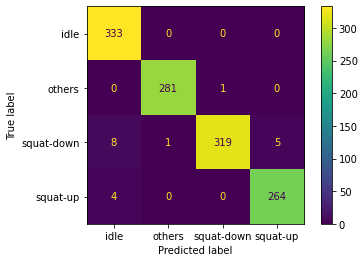

In [46]:
disp.plot()
plt.savefig(os.path.join(save_cm, 'kps_stacked_cm.png'), dpi=300)
plt.show()

Investigate data | Too short seq len?

### ROC AUC

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(raw_test_y, raw_preds_y)

0.9996090929801221

# Detect in realtime

In [49]:
loaded_model = tf.keras.models.load_model(os.path.join(model_dir, f'{EXERCISE}_kps_stacked.h5'))

In [50]:
loaded_model.inputs

[<KerasTensor: shape=(None, 1584) dtype=float32 (created by layer 'input_1')>]

In [51]:
loaded_model.outputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_5')>]

In [52]:
# serialize model and le
with open(os.path.join(pickle_dir, f'{EXERCISE}_kps_stacked_le.pickle'), 'rb') as file:
    loaded_le = pickle.load(file)

In [53]:
from collections import deque, Counter

In [54]:
NUM_TEST_VIDS = 3
exercise = EXERCISE
for i in range(1,1+NUM_TEST_VIDS):
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    video_writer = cv2.VideoWriter(os.path.join(output_vid_dir, f'{EXERCISE}_{i}_kps_stacked{SUBFIX_VID_NAME}.avi'), cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)

                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq).flatten()
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    class_name = "None"
                    prob = 0

                # count the rep logic
                current_stage = class_name

                if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
                    rep_count += 1

                previous_stage = current_stage

                print('rep:',rep_count, end='\r')

    #             image = cv2.resize(image, (640, 368))

                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

                # display rep count
                cv2.putText(image, 'Rep', (640-52, 0+15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(rep_count), (640-52, 0+50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

            except Exception as e:
                print('[INFO] error:', e)

            video_writer.write(image)
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        video_writer.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'quat-up 0.9999835598334
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'quat-down 0.999952969333
[INFO] error: 'N

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no a

# Save class for visualization
only best performing model

In [55]:
NUM_TEST_VIDS = 3
exercise = EXERCISE
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)
                
                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq).flatten()
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                        predicted_class.append(voted_pred)
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        predicted_class.append(y_idx)

                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    predicted_class.append(0)
                    class_name = "None"
                    prob = 0

                    
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

            except Exception as e:
                predicted_class.append(0)
                print('[INFO] error:', e)
                
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
        
        temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/len_{SEQ_LEN}/round_{ROUND}'
        if not os.path.exists(temp_save_path):
            os.makedirs(temp_save_path, exist_ok=True)
        with open(os.path.join(temp_save_path, f'test_vid_{i}_kps_stacked{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
            pickle.dump(predicted_class, f)
        cap.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'quat-up 0.9999835598334
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'quat-down 0.999952969333
[INFO] error: 'N

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no a

OSError: [Errno 28] No space left on device: 'saved_pickles/for_visualization/squat/test_vid_3/len_16'